# Over-sampling using LMNN

In [3]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import seaborn as sns
sns.set()

import numpy as np
import itertools

from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize

# Save a nice dark grey as a variable
almost_black = '#262626'

Generate some data with dimension reduction to observed something.

/home/glemaitre/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


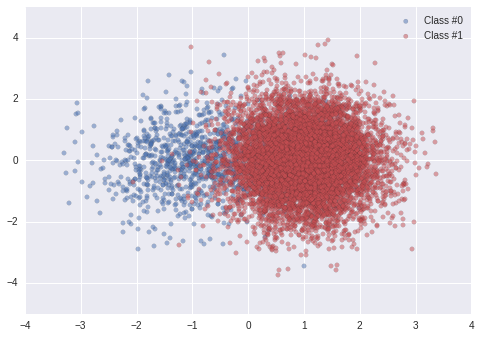

In [4]:
# Generate some data
x, y = make_classification(n_features=2, n_redundant=0, n_informative=1, class_sep=1.,
                           n_clusters_per_class=1, n_samples=10000, weights=[0.1, 0.9],
                           random_state=9)

# Instanciate a PCA object for the sake of easy visualisation
# pca = PCA(n_components = 2)

# Fit and transform x to visualise inside a 2D feature space
# x_vis = pca.fit_transform(x)

# Plot the original data
# Plot the two classes
palette = sns.color_palette()
plt.scatter(x[y==0, 0], x[y==0, 1], label="Class #0", alpha=0.5, 
            edgecolor=almost_black, facecolor=palette[0], linewidth=0.15)
plt.scatter(x[y==1, 0], x[y==1, 1], label="Class #1", alpha=0.5, 
            edgecolor=almost_black, facecolor=palette[2], linewidth=0.15)

plt.legend()
plt.show()

Compute the LMNN for each sample of the minority class

Counter({0: 18, 1: 6})
Counter({0: 18})
Counter({0: 19})
Counter({1: 2294, 0: 19})
Counter({1: 43, 0: 19})
Counter({0: 19, 1: 1})
Counter({1: 23, 0: 19})
Counter({0: 19, 1: 1})
Counter({0: 18, 1: 15})


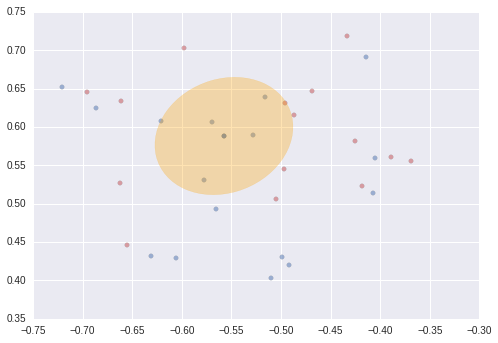

Counter({0: 19})
Counter({0: 19})
Counter({0: 18})
Counter({1: 636, 0: 19})
Counter({0: 19})
Counter({0: 19})
Counter({0: 19})
Counter({1: 43, 0: 19})
Counter({1: 1476, 0: 19})
Counter({0: 19, 1: 2})
Counter({0: 19, 1: 1})
Counter({0: 19, 1: 2})
Counter({0: 19, 1: 1})
Counter({0: 19, 1: 10})


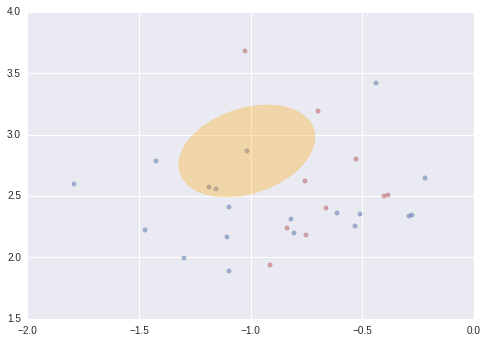

Counter({1: 1571, 0: 19})
Counter({0: 18, 1: 1})
Counter({0: 19, 1: 17})


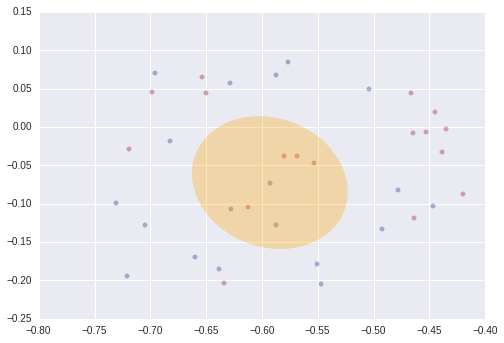

Counter({0: 19, 1: 6})
Counter({0: 19})
Counter({0: 19, 1: 1})
Counter({0: 19, 1: 1})
Counter({0: 19, 1: 3})
Counter({0: 18})
Counter({0: 19})
Counter({0: 19, 1: 1})
Counter({0: 18, 1: 5})
Counter({0: 19, 1: 11})


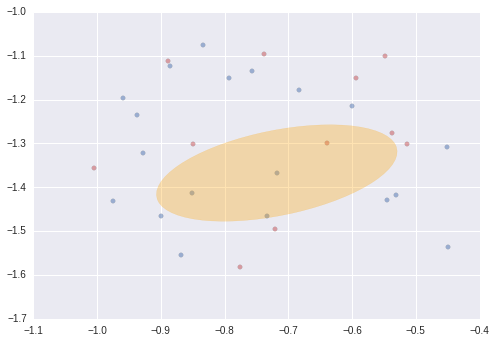

Counter({1: 84, 0: 19})
Counter({0: 19, 1: 2})
Counter({0: 19, 1: 13})


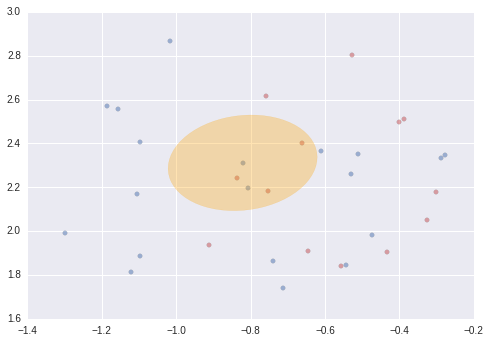

Counter({0: 19, 1: 4})
Counter({0: 19})
Counter({1: 90, 0: 18})
Counter({0: 18})
Counter({0: 18})
Counter({1: 124, 0: 19})
Counter({0: 19, 1: 12})


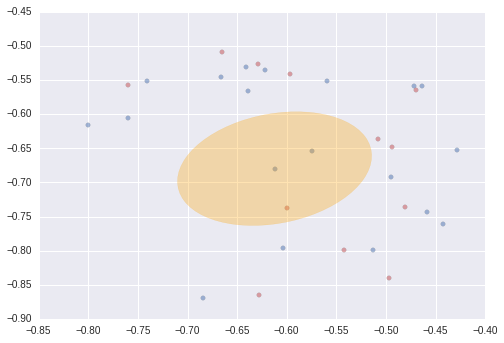

Counter({0: 19})
Counter({1: 286, 0: 19})
Counter({1: 177, 0: 19})
Counter({0: 18, 1: 6})
Counter({0: 19, 1: 4})
Counter({1: 858, 0: 19})
Counter({0: 19})
Counter({0: 19})
Counter({0: 19})
Counter({0: 19, 1: 5})
Counter({0: 19})
Counter({1: 21, 0: 19})
Counter({0: 19, 1: 6})
Counter({1: 39, 0: 18})
Counter({1: 2509, 0: 19})
Counter({0: 19, 1: 12})


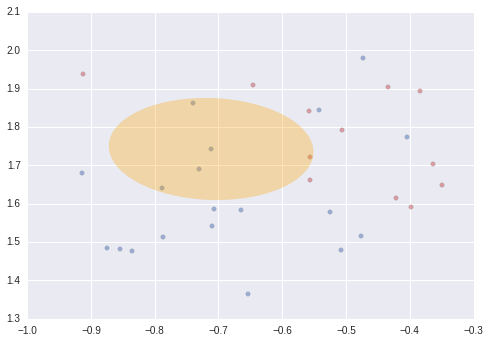

Counter({1: 692, 0: 19})
Counter({1: 288, 0: 19})
Counter({0: 19, 1: 2})
Counter({1: 526, 0: 19})
Counter({1: 647, 0: 19})
Counter({0: 19, 1: 2})
Counter({0: 19})
Counter({0: 18, 1: 6})
Counter({0: 19, 1: 9})
Counter({1: 326, 0: 19})
Counter({0: 19})
Counter({0: 19, 1: 1})
Counter({0: 18})
Counter({1: 178, 0: 18})
Counter({0: 19, 1: 1})
Counter({0: 19, 1: 10})


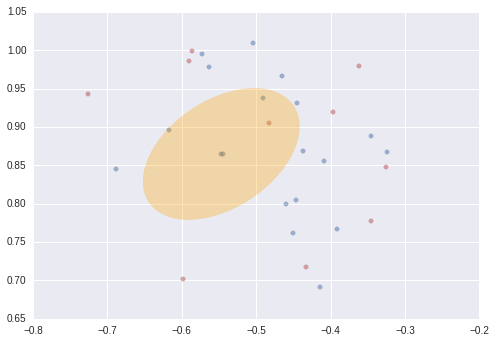

Counter({1: 34, 0: 19})
Counter({0: 19})
Counter({1: 1265, 0: 19})
Counter({0: 19, 1: 1})
Counter({0: 19, 1: 1})
Counter({1: 231, 0: 19})
Counter({0: 19})
Counter({1: 218, 0: 19})
Counter({0: 19, 1: 2})
Counter({1: 71, 0: 19})
Counter({0: 19})
Counter({0: 19, 1: 14})


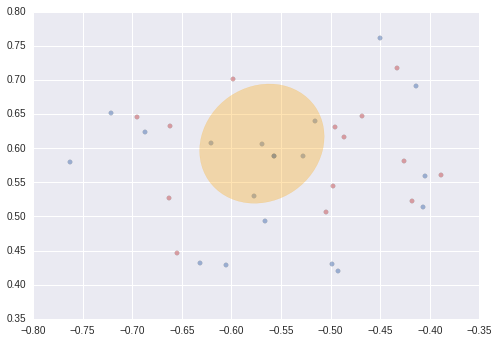

Counter({0: 19})
Counter({0: 18, 1: 5})
Counter({0: 18, 1: 3})
Counter({0: 18, 1: 2})
Counter({1: 214, 0: 19})
Counter({0: 19})
Counter({0: 19})
Counter({0: 19})
Counter({0: 19, 1: 9})
Counter({1: 546, 0: 19})
Counter({0: 19})
Counter({0: 18})
Counter({1: 678, 0: 19})
Counter({0: 19, 1: 16})


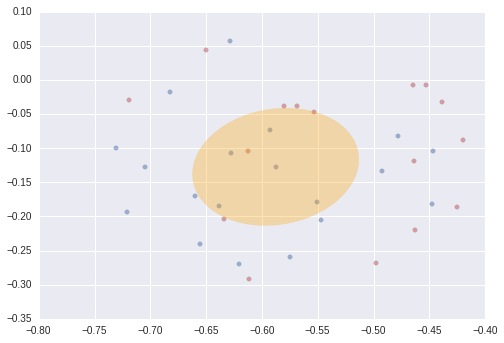

Counter({0: 19, 1: 1})
Counter({0: 19})
Counter({0: 19})
Counter({1: 34, 0: 18})
Counter({0: 19})
Counter({1: 174, 0: 19})
Counter({0: 19, 1: 7})
Counter({0: 19})
Counter({0: 19})
Counter({1: 184, 0: 19})
Counter({0: 19, 1: 15})


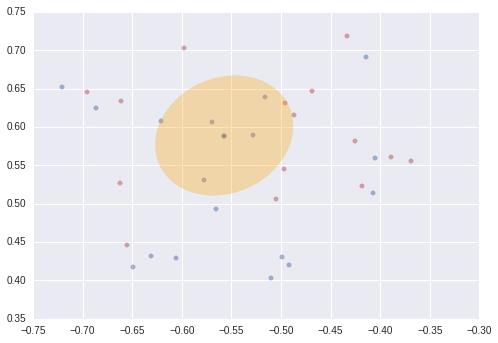

Counter({1: 258, 0: 19})
Counter({0: 18, 1: 1})
Counter({0: 19, 1: 4})
Counter({0: 19})
Counter({0: 18, 1: 5})
Counter({1: 441, 0: 19})
Counter({1: 1022, 0: 19})
Counter({0: 18, 1: 7})
Counter({0: 19, 1: 9})
Counter({0: 19, 1: 1})
Counter({0: 18, 1: 8})
Counter({1: 111, 0: 19})
Counter({0: 19})
Counter({1: 207, 0: 19})
Counter({0: 19, 1: 2})
Counter({0: 18, 1: 2})
Counter({1: 3019, 0: 18})
Counter({1: 180, 0: 18})
Counter({1: 26, 0: 19})
Counter({0: 19})
Counter({1: 1423, 0: 19})
Counter({0: 19, 1: 3})
Counter({0: 19, 1: 1})
Counter({1: 55, 0: 19})
Counter({0: 19, 1: 4})
Counter({0: 19, 1: 15})


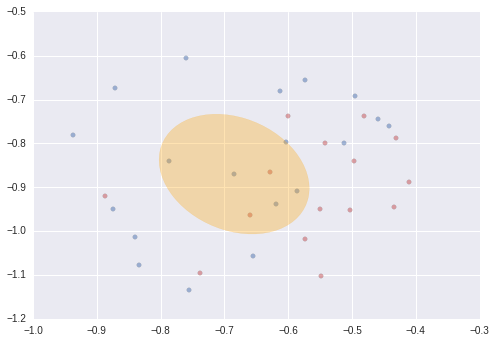

Counter({0: 19})
Counter({0: 19, 1: 17})


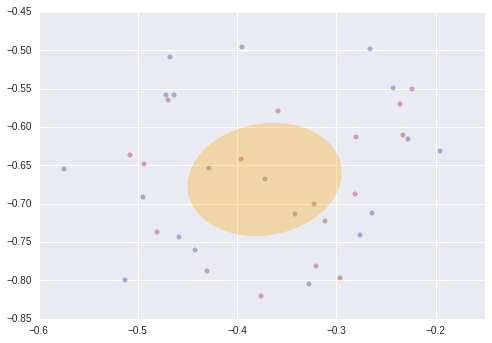

Counter({1: 30, 0: 19})
Counter({1: 1431, 0: 19})
Counter({0: 19, 1: 1})
Counter({0: 19})
Counter({0: 18})
Counter({0: 18})
Counter({1: 95, 0: 19})
Counter({0: 18, 1: 4})
Counter({1: 260, 0: 19})
Counter({0: 19, 1: 1})
Counter({0: 19})
Counter({1: 31, 0: 19})
Counter({1: 466, 0: 18})
Counter({1: 226, 0: 18})
Counter({0: 19, 1: 17})


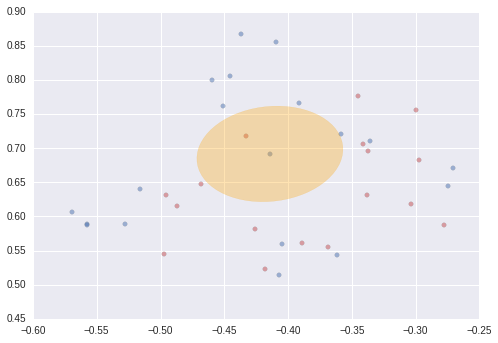

Counter({0: 19, 1: 4})
Counter({0: 18, 1: 11})


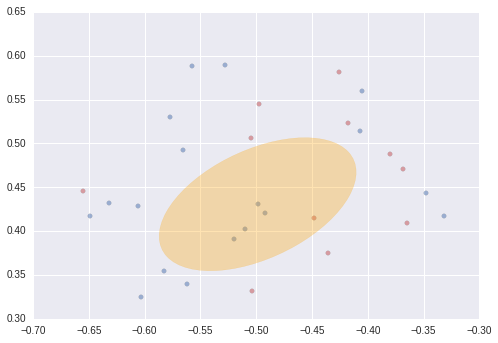

Counter({1: 1253, 0: 18})
Counter({0: 19, 1: 14})


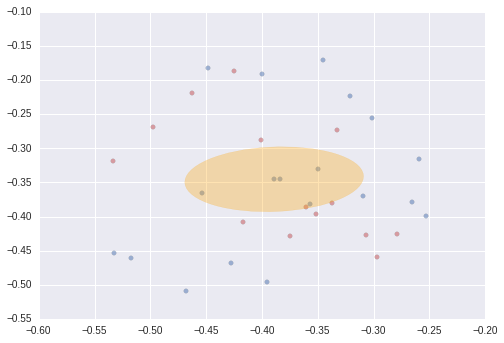

Counter({0: 19})
Counter({0: 19})
Counter({0: 18})
Counter({1: 54, 0: 19})
Counter({0: 19, 1: 15})


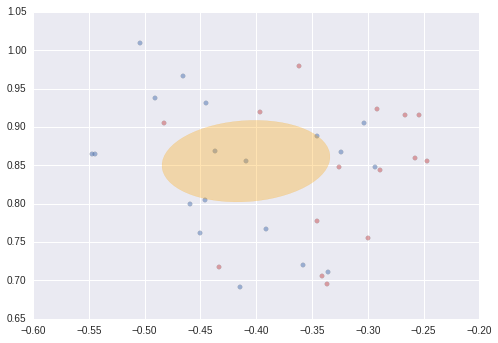

Counter({1: 301, 0: 18})
Counter({0: 18, 1: 3})
Counter({0: 18})
Counter({0: 19, 1: 8})
Counter({1: 296, 0: 18})
Counter({0: 19, 1: 1})
Counter({1: 42, 0: 19})
Counter({0: 19, 1: 3})
Counter({0: 19})
Counter({0: 19})
Counter({1: 1160, 0: 18})
Counter({0: 19})
Counter({0: 19, 1: 2})
Counter({0: 18})
Counter({1: 661, 0: 19})
Counter({0: 19})
Counter({0: 19, 1: 4})
Counter({0: 19, 1: 3})
Counter({1: 125, 0: 19})
Counter({1: 83, 0: 19})
Counter({0: 18, 1: 15})


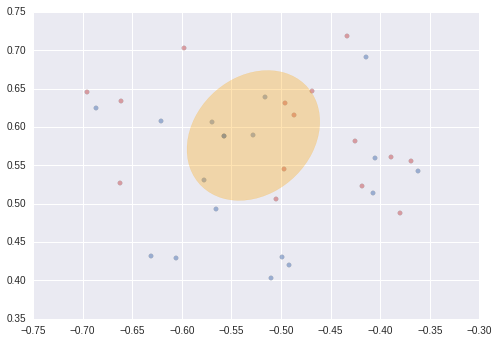

Counter({1: 1307, 0: 19})
Counter({0: 18, 1: 1})
Counter({0: 19, 1: 10})


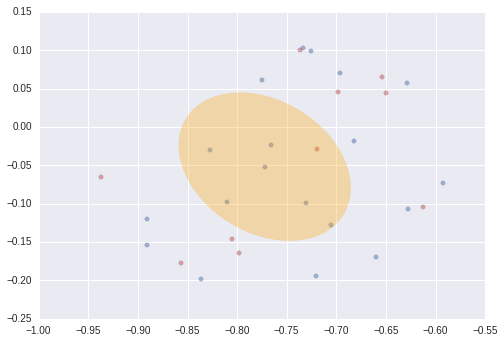

Counter({1: 274, 0: 19})
Counter({0: 19, 1: 3})
Counter({0: 18, 1: 2})
Counter({1: 89, 0: 19})
Counter({0: 19, 1: 1})
Counter({1: 107, 0: 18})
Counter({0: 19})
Counter({0: 19, 1: 1})
Counter({1: 95, 0: 19})
Counter({0: 19, 1: 1})
Counter({0: 19, 1: 1})
Counter({0: 19})
Counter({0: 19, 1: 1})
Counter({0: 19, 1: 2})
Counter({1: 184, 0: 18})
Counter({0: 18})
Counter({1: 40, 0: 19})
Counter({0: 19})
Counter({0: 19})
Counter({1: 1281, 0: 19})
Counter({1: 35, 0: 18})
Counter({1: 20, 0: 19})
Counter({1: 140, 0: 19})
Counter({0: 19, 1: 1})
Counter({0: 18, 1: 5})
Counter({0: 19, 1: 10})


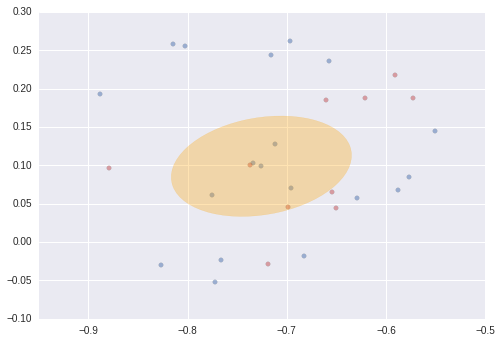

Counter({0: 19})
Counter({0: 19, 1: 1})
Counter({1: 230, 0: 19})
Counter({0: 19, 1: 1})
Counter({0: 18, 1: 1})
Counter({0: 18, 1: 3})
Counter({0: 19, 1: 15})


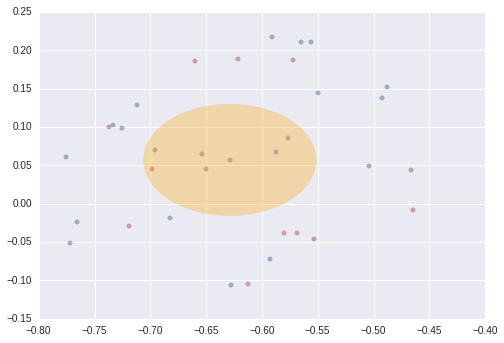

Counter({1: 196, 0: 19})
Counter({0: 19})
Counter({1: 1377, 0: 19})
Counter({0: 19, 1: 1})
Counter({1: 22, 0: 19})
Counter({0: 19})
Counter({0: 19})
Counter({1: 585, 0: 18})
Counter({0: 18, 1: 6})
Counter({0: 19})
Counter({1: 20, 0: 19})
Counter({0: 19})
Counter({0: 19})
Counter({1: 21, 0: 18})
Counter({0: 18})
Counter({0: 19})
Counter({1: 375, 0: 19})
Counter({0: 18})
Counter({0: 19})
Counter({0: 18, 1: 1})
Counter({0: 19})
Counter({0: 18, 1: 6})
Counter({0: 19})
Counter({1: 1642, 0: 19})
Counter({0: 19})
Counter({0: 19, 1: 12})


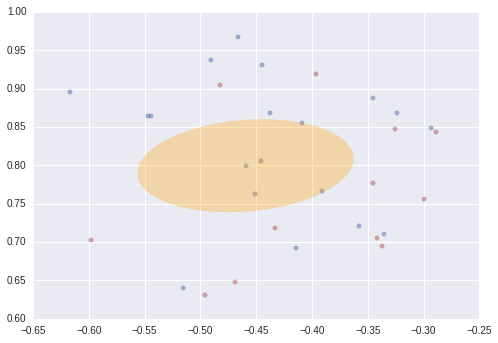

Counter({1: 92, 0: 19})
Counter({1: 192, 0: 19})
Counter({0: 19})
Counter({0: 19, 1: 19})
Counter({0: 19, 1: 1})
Counter({1: 149, 0: 19})
Counter({0: 19})
Counter({0: 19, 1: 1})
Counter({0: 19, 1: 2})
Counter({0: 19})
Counter({0: 19})
Counter({0: 19})
Counter({0: 18, 1: 1})
Counter({0: 18, 1: 1})
Counter({0: 19, 1: 10})


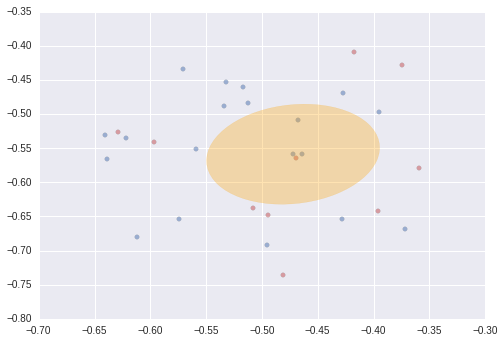

Counter({0: 18})
Counter({0: 18, 1: 15})


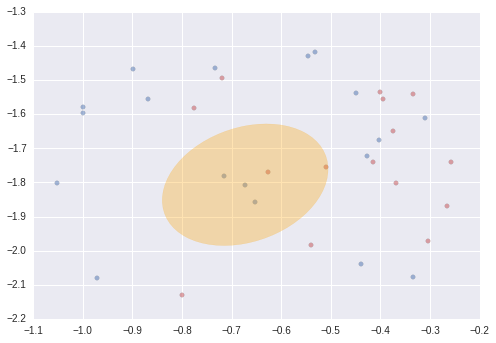

Counter({0: 19, 1: 1})
Counter({0: 19})
Counter({0: 19, 1: 1})
Counter({0: 19})
Counter({0: 19, 1: 1})
Counter({0: 19, 1: 11})


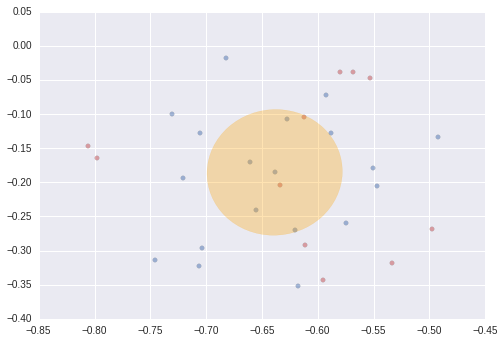

Counter({0: 19, 1: 9})
Counter({0: 18, 1: 7})
Counter({1: 78, 0: 19})
Counter({0: 19})
Counter({0: 19})
Counter({1: 1679, 0: 18})
Counter({0: 19})
Counter({0: 19, 1: 1})
Counter({1: 420, 0: 18})
Counter({0: 18})
Counter({1: 23, 0: 19})
Counter({0: 19, 1: 3})
Counter({1: 369, 0: 18})
Counter({1: 26, 0: 19})
Counter({1: 53, 0: 18})
Counter({0: 19})
Counter({0: 19})
Counter({0: 19})
Counter({0: 19})
Counter({0: 18, 1: 7})
Counter({0: 19, 1: 7})
Counter({1: 1149, 0: 19})
Counter({1: 2034, 0: 19})
Counter({0: 19, 1: 1})
Counter({0: 19, 1: 6})
Counter({0: 19})
Counter({0: 18, 1: 2})
Counter({0: 19, 1: 3})
Counter({0: 19, 1: 5})
Counter({0: 18, 1: 1})
Counter({1: 20, 0: 19})
Counter({0: 19, 1: 3})
Counter({1: 33, 0: 19})
Counter({1: 2503, 0: 18})
Counter({0: 19})
Counter({1: 23, 0: 19})
Counter({0: 19, 1: 1})
Counter({0: 19, 1: 1})
Counter({1: 199, 0: 18})
Counter({1: 26, 0: 19})
Counter({0: 19})
Counter({0: 19})
Counter({0: 19, 1: 1})
Counter({1: 2242, 0: 19})
Counter({1: 25, 0: 18})
Counter

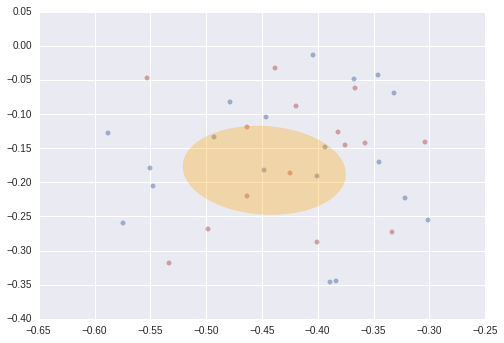

Counter({0: 18, 1: 9})
Counter({1: 31, 0: 19})
Counter({1: 247, 0: 19})
Counter({0: 19, 1: 5})
Counter({1: 41, 0: 18})
Counter({0: 19, 1: 2})
Counter({0: 19, 1: 1})
Counter({0: 19})
Counter({1: 1313, 0: 19})
Counter({0: 19, 1: 1})
Counter({0: 19, 1: 6})
Counter({1: 22, 0: 19})
Counter({0: 19, 1: 19})
Counter({0: 19, 1: 2})
Counter({1: 265, 0: 19})
Counter({1: 320, 0: 19})
Counter({1: 169, 0: 19})
Counter({0: 18})
Counter({0: 19, 1: 1})
Counter({0: 19, 1: 3})
Counter({0: 19, 1: 1})
Counter({0: 19, 1: 14})


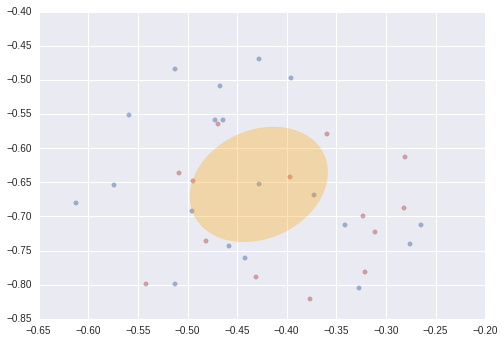

Counter({0: 19, 1: 1})
Counter({0: 19})
Counter({1: 46, 0: 19})
Counter({1: 38, 0: 19})
Counter({1: 1915, 0: 19})
Counter({1: 73, 0: 19})
Counter({0: 19})
Counter({0: 19})
Counter({0: 18, 1: 1})
Counter({0: 19, 1: 2})
Counter({0: 19})
Counter({0: 19})
Counter({0: 18, 1: 2})
Counter({0: 19})
Counter({0: 19, 1: 7})
Counter({0: 19, 1: 1})
Counter({0: 19, 1: 5})
Counter({0: 19})
Counter({0: 19})
Counter({0: 19})
Counter({1: 893, 0: 19})
Counter({0: 19, 1: 1})
Counter({0: 18})
Counter({0: 19})
Counter({0: 19})
Counter({0: 19})
Counter({0: 18})
Counter({1: 67, 0: 19})
Counter({1: 58, 0: 19})
Counter({0: 19})
Counter({0: 19})
Counter({0: 18, 1: 1})
Counter({1: 2639, 0: 18})
Counter({0: 19, 1: 6})
Counter({0: 19})
Counter({0: 19, 1: 6})
Counter({0: 19, 1: 8})
Counter({0: 19})
Counter({1: 155, 0: 19})
Counter({0: 18})
Counter({0: 18})
Counter({0: 18})
Counter({1: 58, 0: 19})
Counter({0: 19, 1: 1})
Counter({0: 19, 1: 2})
Counter({0: 19, 1: 3})
Counter({0: 18})
Counter({1: 47, 0: 19})
Counter({1:

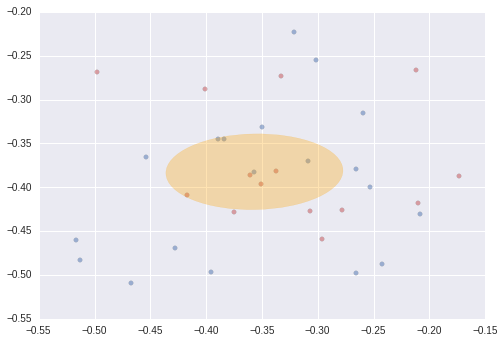

Counter({0: 19})
Counter({0: 18})
Counter({1: 561, 0: 18})
Counter({0: 19, 1: 4})
Counter({1: 48, 0: 19})
Counter({0: 19})
Counter({0: 19, 1: 10})


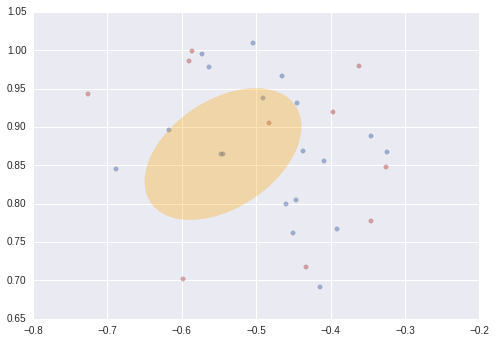

Counter({0: 19, 1: 1})
Counter({0: 19})
Counter({0: 19, 1: 1})
Counter({0: 19, 1: 2})
Counter({0: 18})
Counter({1: 158, 0: 19})
Counter({0: 19})
Counter({1: 37, 0: 19})
Counter({0: 19})
Counter({0: 19, 1: 1})
Counter({0: 19})
Counter({0: 19})
Counter({0: 19, 1: 9})
Counter({0: 19})
Counter({0: 19, 1: 6})
Counter({0: 19, 1: 1})
Counter({0: 19, 1: 4})
Counter({0: 19})
Counter({0: 18, 1: 3})
Counter({0: 18})
Counter({1: 230, 0: 19})
Counter({1: 60, 0: 19})
Counter({0: 19, 1: 2})
Counter({1: 96, 0: 19})
Counter({0: 18})
Counter({0: 19, 1: 9})
Counter({0: 19})
Counter({0: 19, 1: 1})
Counter({0: 19, 1: 9})
Counter({0: 19})
Counter({1: 20, 0: 19})
Counter({1: 93, 0: 19})
Counter({0: 19, 1: 1})
Counter({0: 18})
Counter({0: 19, 1: 5})
Counter({1: 20, 0: 19})
Counter({0: 19, 1: 14})


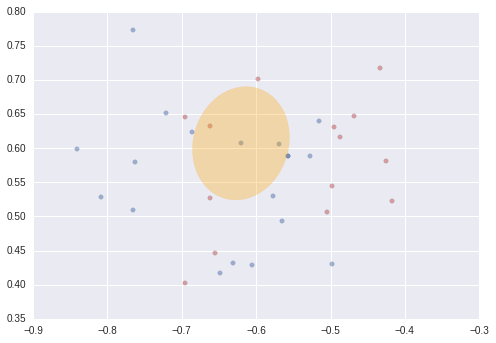

Counter({0: 18, 1: 16})


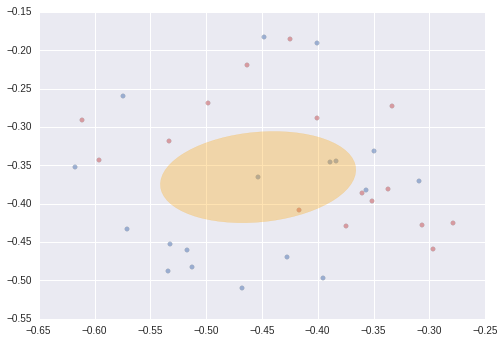

Counter({1: 36, 0: 19})
Counter({0: 19, 1: 1})
Counter({1: 23, 0: 19})
Counter({0: 19, 1: 4})
Counter({0: 19, 1: 1})
Counter({1: 1296, 0: 19})
Counter({1: 110, 0: 19})
Counter({0: 19, 1: 17})


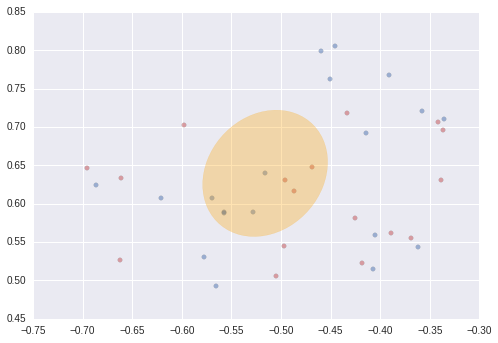

Counter({0: 19})
Counter({1: 30, 0: 19})
Counter({1: 1210, 0: 19})
Counter({0: 19})
Counter({0: 19})
Counter({0: 19, 1: 12})


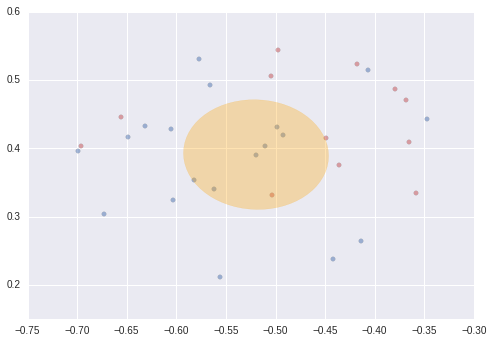

Counter({0: 19, 1: 17})


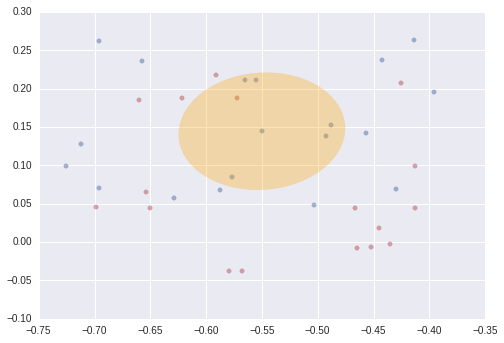

Counter({0: 19, 1: 6})
Counter({0: 19})
Counter({0: 18})
Counter({0: 19})
Counter({1: 121, 0: 19})
Counter({1: 811, 0: 19})
Counter({1: 20, 0: 19})
Counter({1: 192, 0: 19})
Counter({1: 2133, 0: 19})
Counter({0: 18})
Counter({0: 19, 1: 8})
Counter({0: 19})
Counter({1: 68, 0: 18})
Counter({0: 19})
Counter({0: 18})
Counter({0: 18, 1: 1})
Counter({0: 19, 1: 3})
Counter({0: 19, 1: 3})
Counter({0: 19})
Counter({0: 19, 1: 7})
Counter({0: 19})
Counter({0: 18})
Counter({1: 28, 0: 18})
Counter({1: 107, 0: 18})
Counter({1: 118, 0: 18})
Counter({1: 31, 0: 19})
Counter({0: 19, 1: 6})
Counter({0: 19, 1: 3})
Counter({0: 19})
Counter({0: 19})
Counter({1: 67, 0: 19})
Counter({1: 21, 0: 18})
Counter({0: 18})
Counter({0: 19, 1: 1})
Counter({0: 19, 1: 3})
Counter({1: 21, 0: 19})
Counter({1: 1569, 0: 19})
Counter({0: 19})
Counter({0: 19, 1: 3})
Counter({0: 18})
Counter({1: 48, 0: 19})
Counter({1: 280, 0: 19})
Counter({0: 19, 1: 1})
Counter({0: 19, 1: 17})


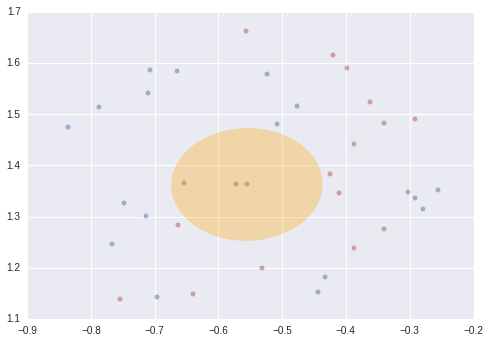

Counter({1: 488, 0: 19})
Counter({1: 253, 0: 19})
Counter({0: 19})
Counter({0: 19})
Counter({0: 19, 1: 15})


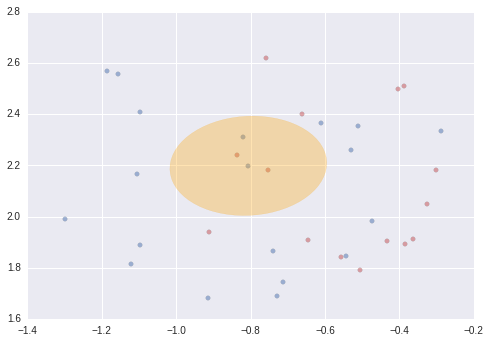

Counter({0: 18, 1: 1})
Counter({0: 19, 1: 6})
Counter({0: 18, 1: 1})
Counter({0: 19, 1: 14})


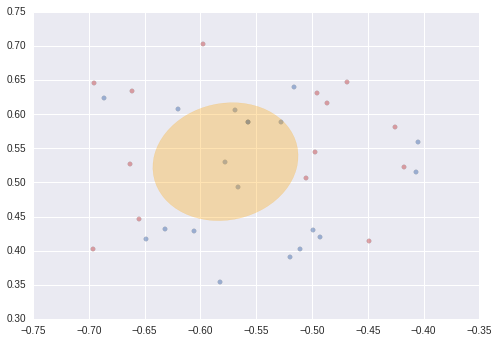

Counter({0: 19, 1: 1})
Counter({1: 40, 0: 19})
Counter({1: 103, 0: 18})
Counter({1: 26, 0: 18})
Counter({0: 18, 1: 2})
Counter({0: 19, 1: 1})
Counter({0: 18, 1: 1})
Counter({0: 19, 1: 11})


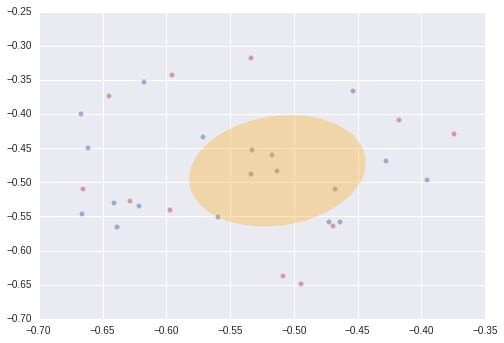

Counter({0: 19, 1: 18})


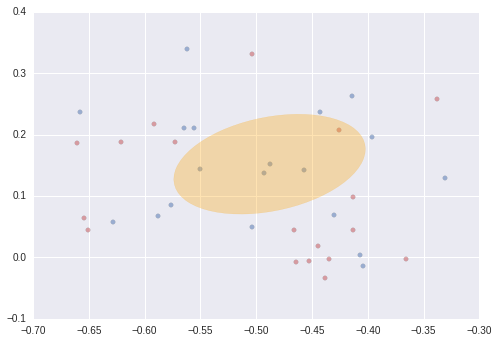

Counter({1: 2234, 0: 18})
Counter({0: 19})
Counter({0: 18, 1: 11})


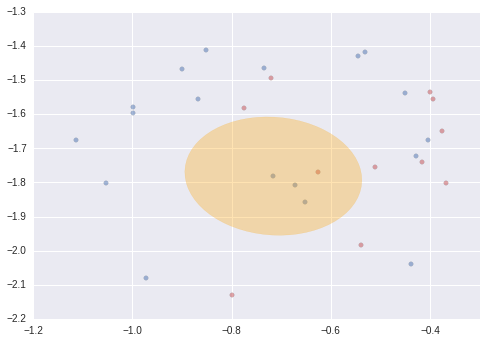

Counter({0: 19, 1: 11})


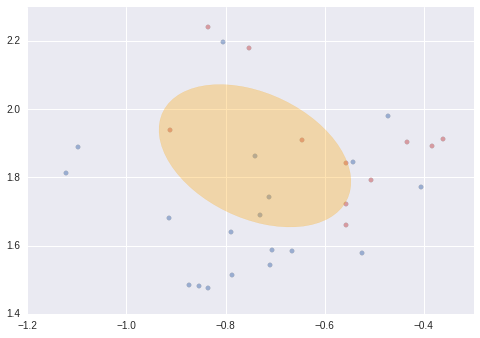

Counter({0: 18})
Counter({0: 18, 1: 6})
Counter({0: 19, 1: 1})
Counter({0: 19, 1: 3})
Counter({1: 23, 0: 18})
Counter({1: 147, 0: 19})
Counter({1: 304, 0: 19})
Counter({1: 1051, 0: 19})
Counter({1: 260, 0: 19})
Counter({0: 19, 1: 18})


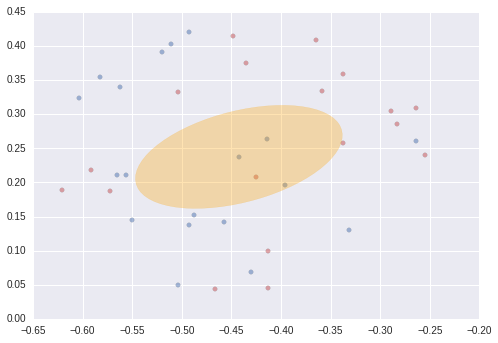

Counter({0: 19})
Counter({0: 19, 1: 2})
Counter({0: 18})
Counter({0: 19})
Counter({1: 22, 0: 19})
Counter({0: 18})
Counter({0: 18})
Counter({0: 19, 1: 13})


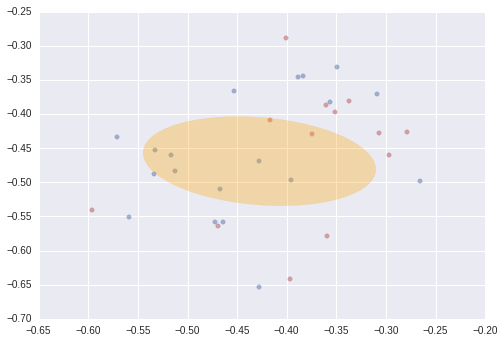

Counter({0: 19, 1: 1})
Counter({0: 19})
Counter({0: 19, 1: 1})
Counter({0: 19, 1: 5})
Counter({0: 19, 1: 3})
Counter({0: 19})
Counter({0: 19, 1: 4})
Counter({0: 18})
Counter({0: 19, 1: 5})
Counter({0: 19, 1: 1})
Counter({0: 19, 1: 1})
Counter({0: 19})
Counter({0: 19, 1: 1})
Counter({0: 18})
Counter({0: 18, 1: 8})
Counter({1: 2465, 0: 19})
Counter({1: 123, 0: 19})
Counter({0: 19, 1: 17})


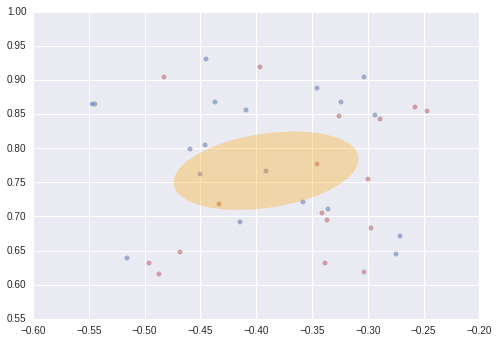

Counter({0: 18, 1: 7})
Counter({1: 473, 0: 19})
Counter({0: 19, 1: 1})
Counter({1: 2148, 0: 19})
Counter({0: 19, 1: 2})
Counter({1: 181, 0: 19})
Counter({0: 19, 1: 1})
Counter({0: 19})
Counter({1: 1621, 0: 18})
Counter({0: 19})
Counter({0: 19})
Counter({0: 19, 1: 14})


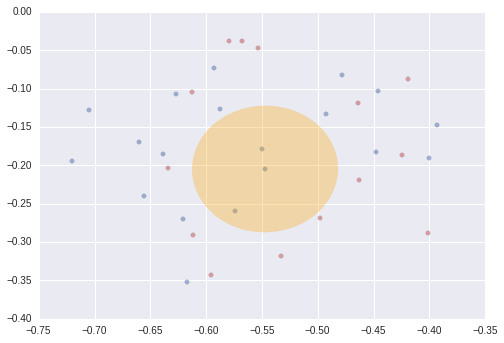

Counter({0: 19})
Counter({0: 19})
Counter({0: 19, 1: 9})
Counter({0: 19, 1: 1})
Counter({1: 49, 0: 19})
Counter({0: 19, 1: 3})
Counter({0: 19, 1: 1})
Counter({0: 19})
Counter({1: 2783, 0: 19})
Counter({0: 19, 1: 1})
Counter({1: 40, 0: 19})
Counter({1: 83, 0: 19})
Counter({0: 19, 1: 5})
Counter({1: 767, 0: 18})
Counter({0: 19})
Counter({0: 19, 1: 1})
Counter({1: 127, 0: 19})
Counter({1: 134, 0: 19})
Counter({1: 49, 0: 19})
Counter({0: 19})
Counter({0: 19})
Counter({1: 114, 0: 19})
Counter({0: 19, 1: 4})
Counter({0: 18})
Counter({1: 21, 0: 19})
Counter({0: 19, 1: 2})
Counter({0: 19, 1: 8})
Counter({1: 154, 0: 18})
Counter({0: 19, 1: 8})
Counter({0: 18})
Counter({0: 19, 1: 9})
Counter({0: 19, 1: 10})


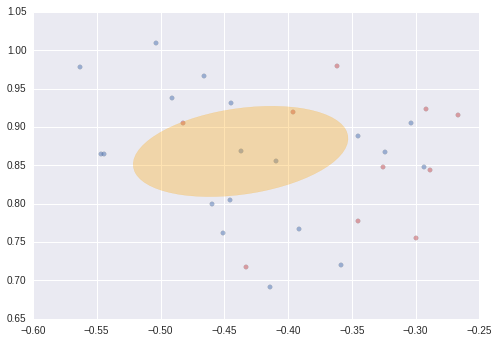

Counter({0: 19, 1: 3})
Counter({1: 166, 0: 19})
Counter({1: 28, 0: 19})
Counter({0: 19})
Counter({0: 18, 1: 1})
Counter({0: 18})
Counter({0: 19})
Counter({0: 19})
Counter({0: 19, 1: 5})
Counter({0: 19, 1: 2})
Counter({1: 100, 0: 18})
Counter({1: 21, 0: 19})
Counter({0: 19, 1: 3})
Counter({1: 138, 0: 19})
Counter({1: 1012, 0: 19})
Counter({1: 1573, 0: 18})
Counter({1: 61, 0: 19})
Counter({0: 19, 1: 2})
Counter({0: 19, 1: 5})
Counter({0: 18, 1: 5})
Counter({0: 19, 1: 7})
Counter({1: 68, 0: 18})
Counter({0: 19})
Counter({0: 19, 1: 5})
Counter({1: 34, 0: 19})
Counter({1: 61, 0: 19})
Counter({0: 19, 1: 13})


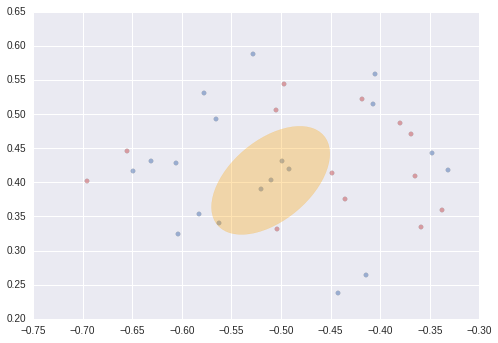

Counter({0: 19})
Counter({1: 187, 0: 19})
Counter({0: 19, 1: 1})
Counter({0: 19, 1: 10})


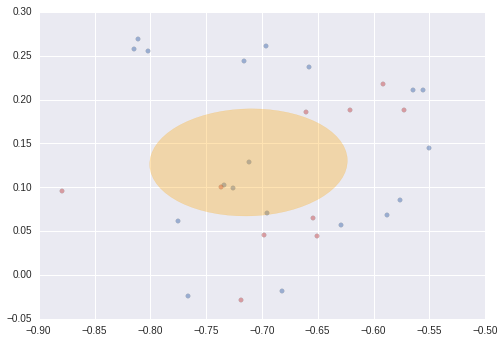

Counter({1: 412, 0: 19})
Counter({0: 19})
Counter({0: 19, 1: 1})
Counter({0: 19, 1: 2})
Counter({0: 19})
Counter({0: 18})
Counter({1: 147, 0: 18})
Counter({0: 18})
Counter({1: 26, 0: 19})
Counter({0: 19, 1: 4})
Counter({0: 18, 1: 7})
Counter({1: 125, 0: 19})
Counter({0: 19})
Counter({1: 203, 0: 18})
Counter({0: 18})
Counter({0: 19, 1: 7})
Counter({0: 18})
Counter({0: 19})
Counter({0: 19, 1: 1})
Counter({1: 21, 0: 18})
Counter({0: 19, 1: 1})
Counter({1: 130, 0: 19})
Counter({0: 19})
Counter({0: 19})
Counter({0: 19, 1: 1})
Counter({0: 18, 1: 4})
Counter({0: 18})
Counter({1: 24, 0: 19})
Counter({1: 859, 0: 19})
Counter({0: 19})
Counter({0: 18})
Counter({1: 21, 0: 19})
Counter({1: 22, 0: 19})
Counter({0: 19})
Counter({0: 19, 1: 1})
Counter({0: 19})
Counter({1: 91, 0: 18})
Counter({0: 18, 1: 1})
Counter({0: 19, 1: 16})


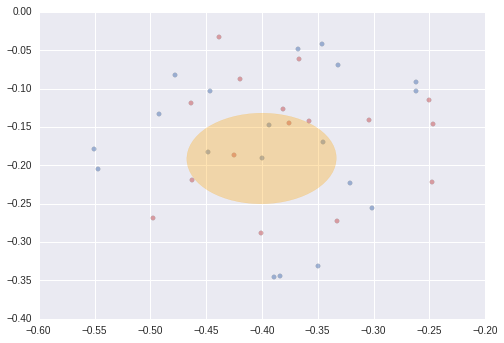

Counter({1: 832, 0: 19})
Counter({0: 19})
Counter({0: 19})
Counter({1: 208, 0: 19})
Counter({0: 19, 1: 10})


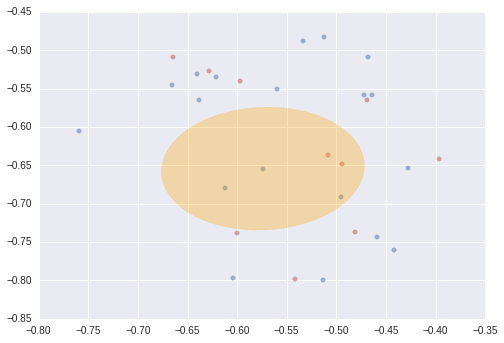

Counter({0: 19})
Counter({0: 19})
Counter({0: 18, 1: 3})
Counter({0: 18})
Counter({0: 19, 1: 1})
Counter({0: 19, 1: 1})
Counter({1: 43, 0: 19})
Counter({0: 18, 1: 5})
Counter({0: 19})
Counter({0: 19, 1: 1})
Counter({1: 185, 0: 19})
Counter({1: 2691, 0: 19})
Counter({1: 43, 0: 19})
Counter({1: 112, 0: 19})
Counter({0: 19})
Counter({1: 90, 0: 19})
Counter({1: 51, 0: 18})
Counter({1: 179, 0: 19})
Counter({1: 209, 0: 19})
Counter({0: 18})
Counter({1: 676, 0: 19})
Counter({0: 19})
Counter({1: 191, 0: 19})
Counter({1: 1923, 0: 19})
Counter({0: 18})
Counter({0: 19})
Counter({1: 340, 0: 19})
Counter({0: 19})
Counter({0: 19, 1: 1})
Counter({1: 202, 0: 19})
Counter({0: 19, 1: 10})


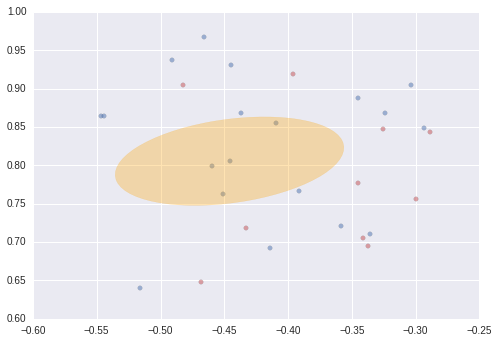

Counter({0: 19})
Counter({0: 19})
Counter({0: 19, 1: 1})
Counter({0: 19})
Counter({0: 19})
Counter({0: 19})
Counter({0: 18, 1: 5})
Counter({1: 967, 0: 19})
Counter({0: 18})
Counter({0: 18, 1: 6})
Counter({1: 871, 0: 19})
Counter({1: 182, 0: 19})
Counter({0: 19, 1: 6})
Counter({1: 115, 0: 19})
Counter({1: 25, 0: 19})
Counter({0: 19, 1: 1})
Counter({0: 19, 1: 4})
Counter({1: 20, 0: 19})
Counter({1: 185, 0: 19})
Counter({0: 19})
Counter({0: 19, 1: 1})
Counter({0: 19})
Counter({0: 19, 1: 1})
Counter({0: 19, 1: 1})
Counter({0: 19})
Counter({0: 19})
Counter({0: 19})
Counter({0: 19, 1: 5})
Counter({0: 18})
Counter({1: 1652, 0: 19})
Counter({0: 19, 1: 2})
Counter({1: 144, 0: 19})
Counter({1: 153, 0: 19})
Counter({0: 19})
Counter({0: 19})
Counter({1: 698, 0: 19})
Counter({1: 43, 0: 19})
Counter({0: 19})
Counter({0: 19, 1: 11})


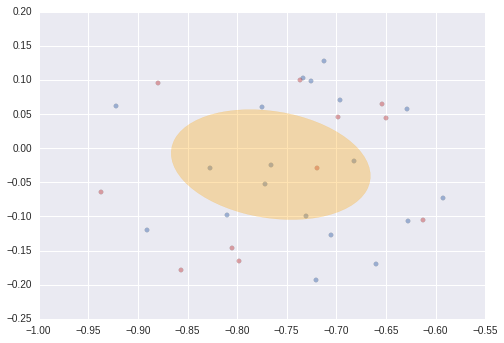

Counter({1: 321, 0: 19})
Counter({0: 19, 1: 1})
Counter({0: 18})
Counter({0: 19, 1: 1})
Counter({0: 19})
Counter({0: 19})
Counter({0: 19})
Counter({1: 323, 0: 19})
Counter({0: 19, 1: 3})
Counter({1: 1001, 0: 19})
Counter({0: 19})
Counter({0: 19})
Counter({0: 18, 1: 1})
Counter({0: 19})
Counter({1: 694, 0: 19})
Counter({0: 18, 1: 12})


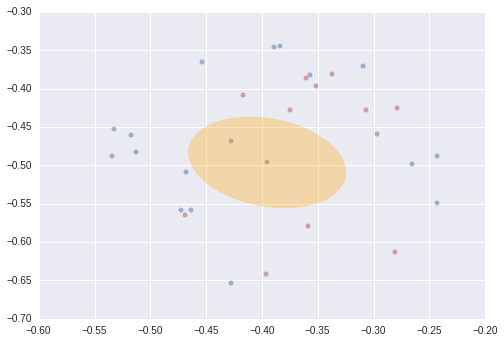

Counter({0: 18, 1: 3})
Counter({0: 19})
Counter({0: 19, 1: 2})
Counter({1: 420, 0: 18})
Counter({0: 19, 1: 3})
Counter({0: 19})
Counter({0: 19, 1: 1})
Counter({1: 542, 0: 19})
Counter({1: 549, 0: 18})
Counter({0: 19})
Counter({0: 19})
Counter({1: 181, 0: 19})
Counter({0: 19, 1: 1})
Counter({0: 19, 1: 2})
Counter({0: 19, 1: 4})
Counter({0: 19, 1: 4})
Counter({0: 18})
Counter({0: 19, 1: 9})
Counter({0: 19})
Counter({0: 19, 1: 3})
Counter({0: 19})
Counter({0: 19, 1: 1})
Counter({1: 307, 0: 19})
Counter({0: 19, 1: 7})
Counter({0: 19})
Counter({0: 19})
Counter({0: 19})
Counter({0: 18, 1: 7})
Counter({0: 19, 1: 1})
Counter({1: 48, 0: 19})
Counter({1: 822, 0: 19})
Counter({0: 18})
Counter({1: 1036, 0: 18})
Counter({1: 27, 0: 18})
Counter({0: 19})
Counter({0: 18, 1: 5})
Counter({1: 389, 0: 19})
Counter({1: 151, 0: 18})
Counter({0: 19, 1: 9})
Counter({0: 19, 1: 3})
Counter({0: 18, 1: 6})
Counter({0: 18, 1: 10})


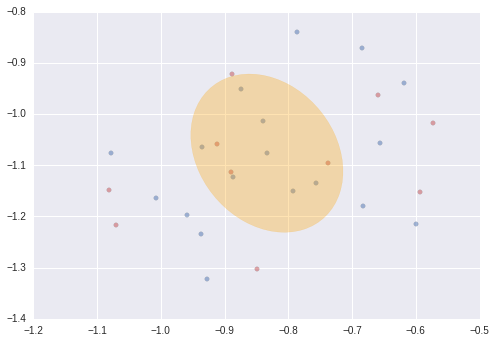

Counter({0: 18})
Counter({0: 19})
Counter({1: 61, 0: 19})
Counter({0: 18})
Counter({1: 378, 0: 18})
Counter({0: 18})
Counter({1: 38, 0: 19})
Counter({1: 1310, 0: 19})
Counter({0: 19, 1: 1})
Counter({0: 19})
Counter({0: 18, 1: 2})
Counter({0: 19, 1: 13})


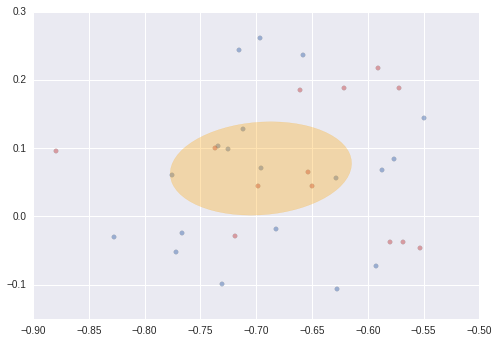

Counter({1: 571, 0: 19})
Counter({0: 19})
Counter({1: 182, 0: 19})
Counter({0: 19, 1: 1})
Counter({1: 34, 0: 19})
Counter({0: 19, 1: 5})
Counter({1: 83, 0: 19})
Counter({0: 19})
Counter({0: 19})
Counter({0: 19, 1: 16})


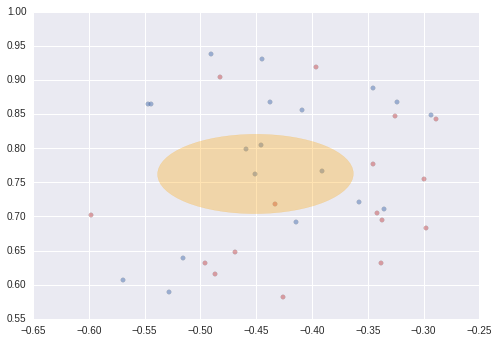

Counter({0: 18, 1: 15})


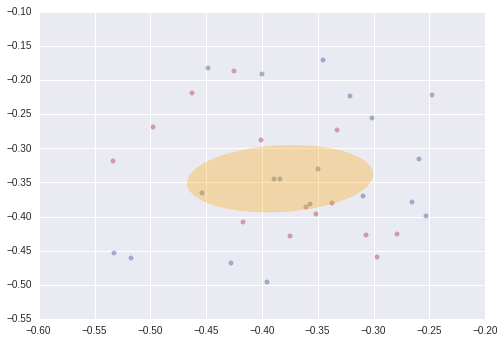

Counter({0: 18})
Counter({1: 20, 0: 18})
Counter({0: 18, 1: 9})
Counter({0: 19})
Counter({0: 19})
Counter({0: 18, 1: 13})


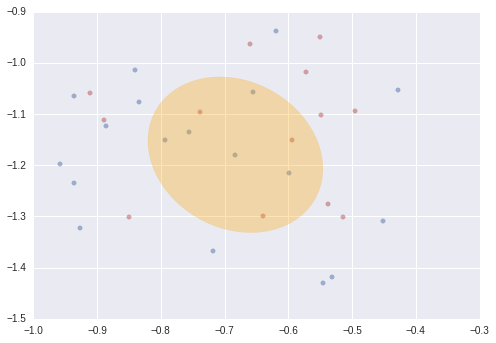

Counter({0: 19})
Counter({0: 19, 1: 1})
Counter({1: 20, 0: 19})
Counter({1: 436, 0: 19})
Counter({0: 18})
Counter({0: 19})
Counter({0: 19})
Counter({1: 72, 0: 19})
Counter({0: 19})
Counter({1: 3175, 0: 19})
Counter({0: 19, 1: 1})
Counter({1: 102, 0: 19})
Counter({1: 67, 0: 19})
Counter({0: 19, 1: 5})
Counter({1: 258, 0: 19})
Counter({1: 117, 0: 19})
Counter({0: 19, 1: 7})
Counter({0: 18, 1: 3})
Counter({0: 19})
Counter({0: 19})
Counter({1: 175, 0: 19})
Counter({0: 18, 1: 1})
Counter({1: 66, 0: 19})
Counter({0: 19})
Counter({0: 18, 1: 1})
Counter({0: 19, 1: 2})
Counter({0: 19})
Counter({0: 19, 1: 6})
Counter({0: 18, 1: 1})
Counter({0: 19, 1: 1})
Counter({0: 19, 1: 10})


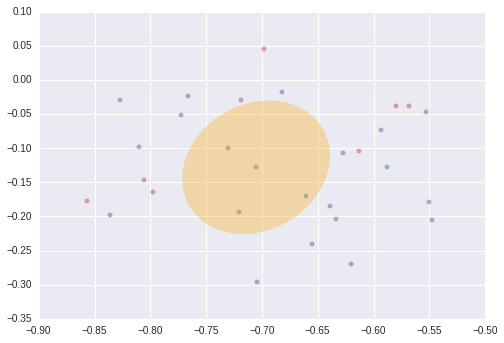

Counter({0: 19})
Counter({0: 19, 1: 6})
Counter({0: 19, 1: 1})
Counter({0: 19})
Counter({1: 232, 0: 19})
Counter({1: 1186, 0: 19})
Counter({0: 19})
Counter({0: 19, 1: 2})
Counter({0: 19, 1: 3})
Counter({0: 19})
Counter({1: 85, 0: 18})
Counter({1: 32, 0: 19})
Counter({0: 19})
Counter({0: 19, 1: 17})


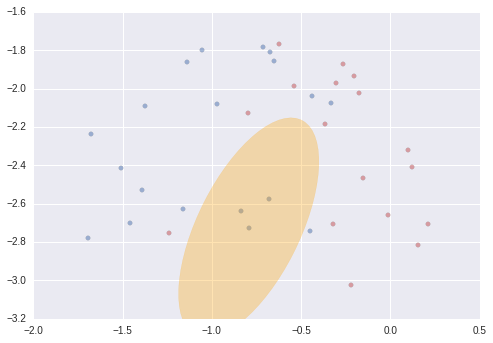

Counter({1: 74, 0: 19})
Counter({0: 19, 1: 1})
Counter({0: 19})
Counter({0: 19, 1: 3})
Counter({0: 18, 1: 1})
Counter({0: 19})
Counter({0: 19})
Counter({1: 106, 0: 19})
Counter({0: 19, 1: 6})
Counter({0: 19, 1: 4})
Counter({0: 19, 1: 2})
Counter({1: 2726, 0: 18})
Counter({0: 19})
Counter({0: 19, 1: 9})
Counter({0: 19, 1: 9})
Counter({0: 18})
Counter({0: 18, 1: 1})
Counter({0: 18})
Counter({0: 19})
Counter({0: 18, 1: 8})
Counter({0: 18, 1: 1})
Counter({0: 18, 1: 9})
Counter({1: 31, 0: 19})
Counter({0: 19})
Counter({0: 19, 1: 1})
Counter({1: 2034, 0: 19})
Counter({0: 19, 1: 2})
Counter({0: 19, 1: 1})
Counter({1: 50, 0: 18})
Counter({0: 19, 1: 1})
Counter({0: 18})
Counter({0: 19})
Counter({0: 19, 1: 1})
Counter({1: 40, 0: 18})
Counter({0: 19, 1: 1})
Counter({0: 19, 1: 1})
Counter({0: 18, 1: 17})


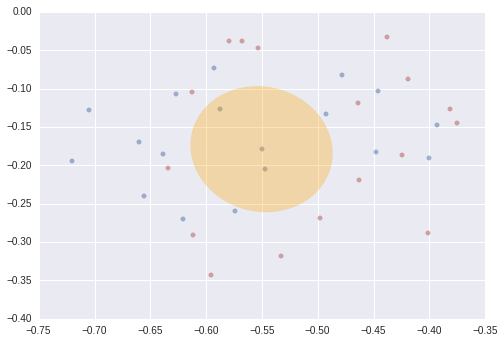

Counter({0: 19})
Counter({0: 19, 1: 19})
Counter({0: 19, 1: 7})
Counter({0: 18, 1: 1})
Counter({0: 19, 1: 1})
Counter({1: 40, 0: 19})
Counter({1: 38, 0: 19})
Counter({0: 19, 1: 4})
Counter({1: 115, 0: 19})
Counter({0: 19, 1: 1})
Counter({0: 19, 1: 1})
Counter({0: 19, 1: 2})
Counter({1: 163, 0: 19})
Counter({0: 19})
Counter({1: 29, 0: 19})
Counter({0: 19})
Counter({0: 19, 1: 3})
Counter({0: 19})
Counter({0: 19, 1: 14})


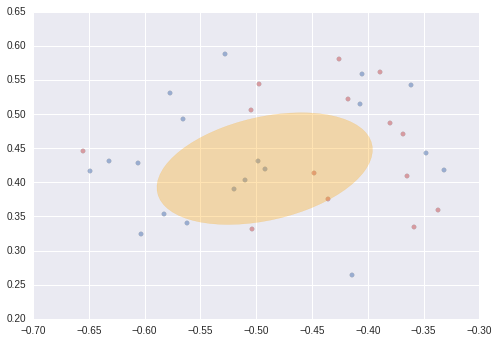

Counter({0: 19, 1: 7})
Counter({0: 19, 1: 1})
Counter({0: 19, 1: 2})
Counter({0: 19})
Counter({0: 19})
Counter({0: 19, 1: 1})
Counter({0: 19, 1: 3})
Counter({0: 19, 1: 1})
Counter({1: 99, 0: 19})
Counter({1: 70, 0: 19})
Counter({1: 1110, 0: 18})
Counter({0: 19, 1: 7})
Counter({0: 19, 1: 10})


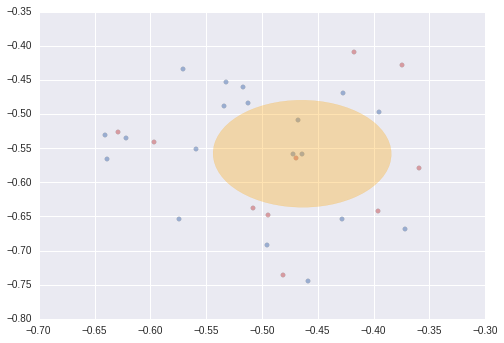

Counter({0: 19})
Counter({0: 18})
Counter({0: 19, 1: 1})
Counter({0: 18, 1: 14})


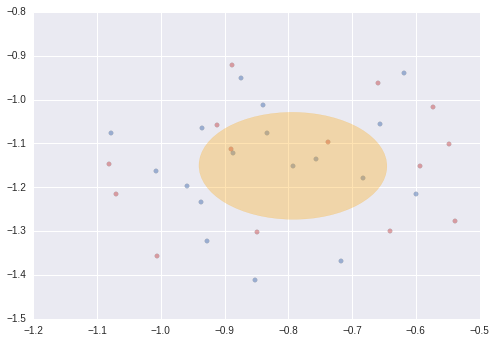

Counter({1: 2622, 0: 19})
Counter({1: 146, 0: 19})
Counter({0: 19, 1: 1})
Counter({1: 77, 0: 19})
Counter({0: 19, 1: 5})
Counter({0: 18})
Counter({0: 19})
Counter({1: 119, 0: 19})
Counter({0: 19, 1: 13})


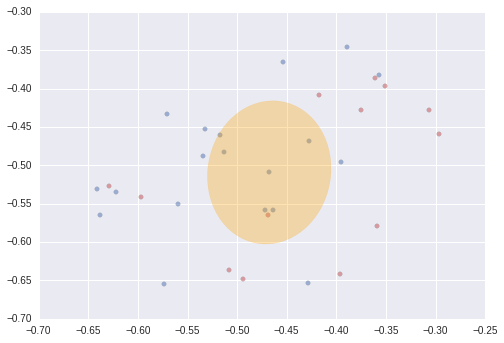

Counter({0: 19, 1: 1})
Counter({1: 23, 0: 19})
Counter({0: 18, 1: 15})


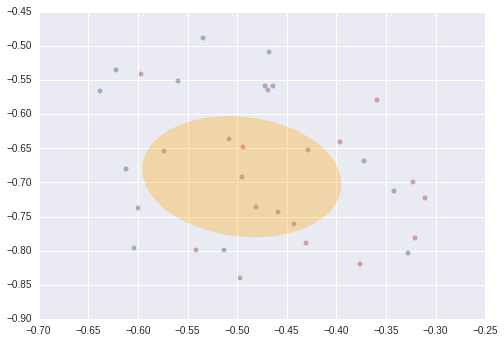

Counter({0: 19, 1: 9})
Counter({0: 19})
Counter({0: 19, 1: 2})
Counter({0: 19})
Counter({0: 19})
Counter({0: 19, 1: 5})
Counter({0: 19, 1: 7})
Counter({0: 19})
Counter({0: 19, 1: 1})
Counter({0: 18, 1: 2})
Counter({0: 19, 1: 7})
Counter({0: 19, 1: 1})
Counter({0: 19, 1: 8})
Counter({0: 19, 1: 1})
Counter({1: 534, 0: 19})
Counter({1: 27, 0: 18})
Counter({1: 888, 0: 19})
Counter({1: 122, 0: 19})
Counter({0: 19, 1: 13})


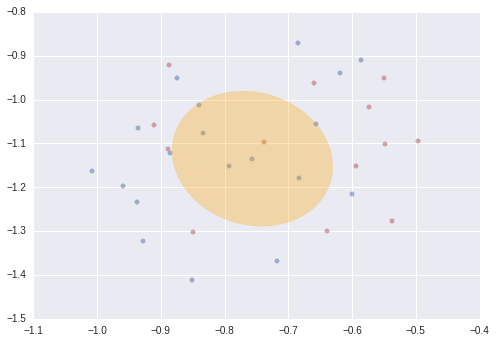

Counter({1: 1299, 0: 19})
Counter({0: 19, 1: 1})
Counter({0: 19, 1: 2})
Counter({0: 19, 1: 17})


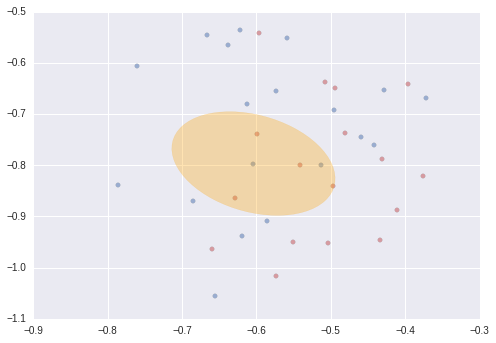

Counter({1: 547, 0: 18})
Counter({0: 19, 1: 1})
Counter({0: 19, 1: 1})
Counter({1: 22, 0: 19})
Counter({0: 19})
Counter({0: 19})
Counter({0: 19, 1: 3})
Counter({0: 18, 1: 11})


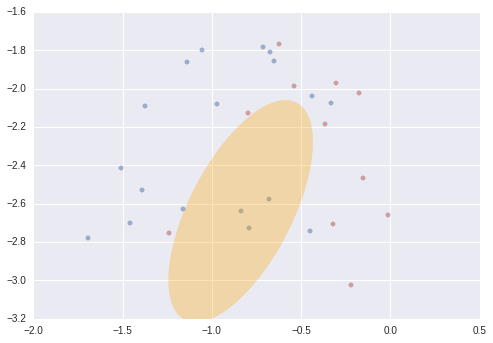

Counter({0: 19, 1: 6})
Counter({0: 19, 1: 1})
Counter({1: 34, 0: 19})
Counter({0: 19})
Counter({1: 53, 0: 19})
Counter({1: 82, 0: 19})
Counter({0: 19})
Counter({0: 19, 1: 1})
Counter({0: 19, 1: 8})
Counter({1: 21, 0: 19})


In [12]:
from collections import Counter

# Compute the classes representation
stat_class = Counter(y)
# Find the minority class key
label_min_class = min(stat_class, key=stat_class.get)
label_maj_class = max(stat_class, key=stat_class.get)
# Save the sample index of this class
idx_min_class = np.ravel(np.nonzero(y == label_min_class))
idx_maj_class = np.ravel(np.nonzero(y == label_maj_class))

from sklearn.neighbors import NearestNeighbors

neighbours_required = 19

# Create an object NN only for the minority class
min_class_NN = NearestNeighbors(n_neighbors=neighbours_required, metric='l2', n_jobs=-1)
min_class_NN.fit(x[idx_min_class, :], y[idx_min_class])

# Create an object NN only for the majority class
max_class_NN = NearestNeighbors(n_neighbors=neighbours_required, metric='l2', n_jobs=-1)
max_class_NN.fit(x[idx_maj_class, :], y[idx_maj_class])

# Create an object NN for the whole dataset
data_NN = NearestNeighbors(n_neighbors=1, metric='l2',n_jobs=-1)
data_NN.fit(x, y)

# Compute all the distance of the k-NN on the minority class on the original data for the point of the minority class
dist_min, ind_min = min_class_NN.kneighbors(x[idx_min_class, :])
# Compute all the distance of the k-NN on the majority class on the original data for the point of the minority class
dist_max, ind_max = max_class_NN.kneighbors(x[idx_min_class, :])
# Find the largest distance for the both above distances
dist_min = np.max(dist_min, axis=1)
dist_max = np.max(dist_max, axis=1)

# Select the max_dist between dist_min and dist_max to ensure a minimum of neighbours
#max_dist = dist_max.copy()
max_dist = dist_min.copy()
#max_dist[np.nonzero(dist_min < dist_max)] = dist_max[np.nonzero(dist_min < dist_max)]
#max_dist[np.nonzero(dist_min > dist_max)] = dist_min[np.nonzero(dist_min > dist_max)]

# Now find the samples to consider with the distance extracted using only the minority class
# We need to loop since that the distance is changing
s_considers = []
for s, d, tmpi in zip(x[idx_min_class], max_dist, idx_min_class):
    dist, ind = data_NN.radius_neighbors(X=np.atleast_2d(s), radius=d)
    a = ind[0]
    # Move to the first position the index of interest
    idxint = np.nonzero(a==tmpi)
    a[idxint] = a[0]
    a[0] = tmpi
    s_considers.append(a)
    
from metric_learn import LMNN

cov_mat = []
idx_cons = []
for s in s_considers:
    # Extract the interesting data
    x_s = x[np.ravel(s), :]
    y_s = y[np.ravel(s)]
        
    # Check if there is any imposter
    stat = Counter(y_s)
    print stat
    
    if (len(stat) > 1):
        if (stat[label_min_class] > stat[label_maj_class]):
            #print (stat[label_maj_class] / stat[label_min_class])
            if ((float(stat[label_min_class]) / float(stat[label_maj_class])) > 1 and 
                (float(stat[label_min_class]) / float(stat[label_maj_class])) < 2):
                # Fit the LMNN for these data
                #s_lmnn = LMNN(k=stat[label_min_class], convergence_tol=1e-9, max_iter=5000)
                s_lmnn = LMNN(k=1, convergence_tol=1e-9, min_iter=5000, max_iter=5000)
                s_lmnn.fit(x_s, y_s)

                figure, axis = plt.subplots(1,1)
                plt.scatter(x_s[y_s==0, 0], x_s[y_s==0, 1], label="Class #0", alpha=0.5, 
                edgecolor=almost_black, facecolor=palette[0], linewidth=0.15)
                plt.scatter(x_s[y_s==1, 0], x_s[y_s==1, 1], label="Class #1", alpha=0.5, 
                edgecolor=almost_black, facecolor=palette[2], linewidth=0.15)
                cm = np.matrix(s_lmnn.metric())
                elli = make_covariance_ellipse(np.matrix(cm).I, x_s[0])
                axis.add_artist(elli)
                plt.show()

                # Store the covariance matrix
                cov_mat.append(np.matrix(s_lmnn.metric()))
                idx_cons.append(True)
            else:
                cov_mat.append(np.ma.cov(x_s.T))
                idx_cons.append(False)
        else:
            cov_mat.append(np.ma.cov(x_s.T))
            idx_cons.append(False)
    else:
        cov_mat.append(np.ma.cov(x_s.T))
        idx_cons.append(False)

In [ ]:
xxxx = [172, 6541, 8670, 9961]
print x[xxxx, :]

Function to plot a covariance with some sigma on the plot

In [ ]:
def plot_cov_ellipse(cov, pos, nstd=2, ax=None, **kwargs):
    """
    Plots an `nstd` sigma error ellipse based on the specified covariance
    matrix (`cov`). Additional keyword arguments are passed on to the 
    ellipse patch artist.

    Parameters
    ----------
        cov : The 2x2 covariance matrix to base the ellipse on
        pos : The location of the center of the ellipse. Expects a 2-element
            sequence of [x0, y0].
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the 
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.

    Returns
    -------
        A matplotlib ellipse artist
    """
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    if ax is None:
        ax = plt.gca()

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

    # Width and height are "full" widths, not radius
    width, height = 2 * nstd * np.sqrt(vals)
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwargs)

    ax.add_artist(ellip)
    ellip.set_alpha(.1)
    return ellip


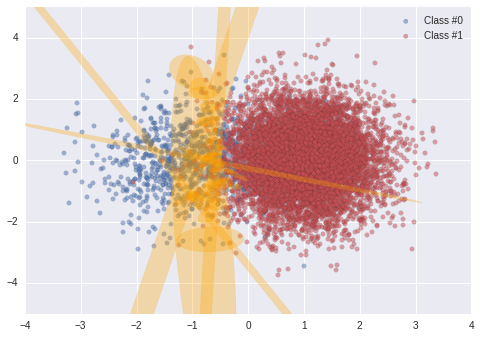

In [11]:
# Plot the data
figure, axis = plt.subplots(1,1)
#plt.figure(figsize=(18,10))
plt.scatter(x[y==0, 0], x[y==0, 1], label="Class #0", alpha=0.5, 
            edgecolor=almost_black, facecolor=palette[0], linewidth=0.15)
plt.scatter(x[y==1, 0], x[y==1, 1], label="Class #1", alpha=0.5, 
            edgecolor=almost_black, facecolor=palette[2], linewidth=0.15)

# For each data, let's plot some elippse
for cm, s, cs in zip(cov_mat, x[idx_min_class], idx_cons):
    if (cs == True):
        #print np.matrix(cm).I
        #print s
        elli = make_covariance_ellipse(np.matrix(cm).I, s)
        axis.add_artist(elli)
    
plt.legend()
plt.show()

In [ ]:
print np.sum(np.sum(np.cov(x_s.T)))

## Easy LMNN example

In [ ]:
x = np.array([[0,0],[-1,0.1],[0.3,-0.05],[0.7,0.3],[-0.2,-0.6],[-0.15,-0.63],[-0.25,0.55],[-0.28,0.67]])
y = np.array([0,0,0,0,1,1,2,2])

In [2]:
import matplotlib.pyplot as pyplot

%matplotlib inline

def plot_data(features,labels,axis,alpha=1.0):
    # separate features according to their class
    X0,X1,X2 = features[labels==0], features[labels==1], features[labels==2]
    
    # class 0 data
    axis.plot(X0[:,0], X0[:,1], 'o', color='green', markersize=12, alpha=alpha)
    # class 1 data
    axis.plot(X1[:,0], X1[:,1], 'o', color='red', markersize=12, alpha=alpha)
    # class 2 data
    axis.plot(X2[:,0], X2[:,1], 'o', color='blue', markersize=12, alpha=alpha)
    
    # set axes limits
    axis.set_xlim(-1.5,1.5)
    axis.set_ylim(-1.5,1.5)
    axis.set_aspect('equal')
    
    axis.set_xlabel('x')
    axis.set_ylabel('y')

figure,axis = plt.subplots(1,1)
plot_data(x,y,axis)
axis.set_title('Toy data set')
plt.show()

NameError: name 'plt' is not defined

TypeError: make_covariance_ellipse() takes exactly 2 arguments (1 given)

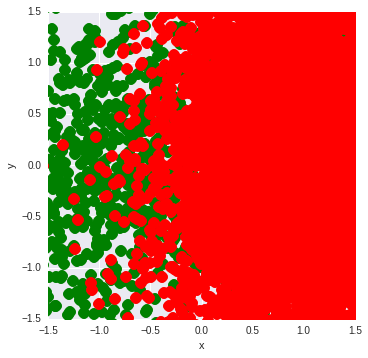

In [6]:
def make_covariance_ellipse(covariance, mean):
    import matplotlib.patches as patches
    import scipy.linalg       as linalg
    
    # the ellipse is centered at (0,0)
    # mean = np.array([0,0])
    
    # eigenvalue decomposition of the covariance matrix (w are eigenvalues and v eigenvectors),
    # keeping only the real part
    w,v = linalg.eigh(covariance)
    # normalize the eigenvector corresponding to the largest eigenvalue
    u = v[0]/linalg.norm(v[0])
    # angle in degrees
    angle = 180.0/np.pi*np.arctan(u[1]/u[0])
    # fill Gaussian ellipse at 2 standard deviation
    ellipse = patches.Ellipse(mean, 2*w[0]**0.5, 2*w[1]**0.5, 180+angle, color='orange', alpha=0.3)
    
    return ellipse

# represent the Euclidean distance
figure,axis = plt.subplots(1,1)
plot_data(x,y,axis)
ellipse = make_covariance_ellipse(np.eye(2))
axis.add_artist(ellipse)
axis.set_title('Euclidean distance')
plt.show()

In [ ]:
# number of target neighbours per example
k = 2

lmnn = LMNN(k, min_iter=50, max_iter=1000, convergence_tol=1e-9)
lmnn.fit(x, y)

In [ ]:
# get the linear transform from LMNN
L = lmnn.transformer()
# square the linear transform to obtain the Mahalanobis distance matrix
M = np.matrix(lmnn.metric())

print M.I

# represent the distance given by LMNN
figure,axis = plt.subplots(1,1)
plot_data(x,y,axis)
ellipse = make_covariance_ellipse(M.I)
axis.add_artist(ellipse)
axis.set_title('LMNN distance')
plt.show()